<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [8]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 1.1576, Train Accuracy: 60.79%
Test Accuracy: 66.99%
Confusion Matrix (Epoch 1):
[[760  11  57   8  29   0   5  15 104  11]
 [ 53 751  10   3   4   2   9   8 134  26]
 [ 72   3 670  34  60  16  91  29  21   4]
 [ 34  10 145 454  62  57 117  69  42  10]
 [ 18   2  99  23 599  10 135 101  12   1]
 [ 13   6 184 176  39 383  28 142  23   6]
 [  3   4  75  40  22   7 832   8   9   0]
 [ 21   4  68  30  58  13  19 776   3   8]
 [ 75   7  19   3  10   2   5   5 863  11]
 [116 144  14   8   8   0  15  35  49 611]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.9681, Train Accuracy: 66.96%
Test Accuracy: 75.16%
Confusion Matrix (Epoch 2):
[[740  15  51   3  15   0   5   6 133  32]
 [ 12 853   4   2   3   6   1   1  43  75]
 [ 61   4 730  20  66  41  34  19  18   7]
 [ 22   8  96 494  68 178  48  39  32  15]
 [ 14   4  79  27 744  16  52  43  20   1]
 [  8   4  78  98  47 665  12  65  17   6]
 [  6  14  85  44  28  20 775   7  15   6]
 [ 25   9  26  23  69  46   7 772  13  10]
 [ 39  21   8   2   4   1   1   3 917   4]
 [ 35  48   6   3   0   2   0  10  70 826]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.7672, Train Accuracy: 73.52%
Test Accuracy: 77.73%
Confusion Matrix (Epoch 3):
[[840  11  37   8  10   2   8  13  55  16]
 [ 21 859   5   0   1   8   3   3  12  88]
 [ 48   0 689  18  76  55  58  42   8   6]
 [ 25   6  48 399  43 327  74  53  14  11]
 [ 11   1  41  18 770  41  47  63   8   0]
 [ 10   3  34  53  28 804  15  49   3   1]
 [  7   8  34  27  27  21 847  20   5   4]
 [ 25   0  15  11  31  69   2 840   2   5]
 [ 76  20   6   5   3   3   1   3 870  13]
 [ 43  45   7   4   0   6   2  11  27 855]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.6810, Train Accuracy: 76.63%
Test Accuracy: 79.29%
Confusion Matrix (Epoch 4):
[[841  19  25   1  29   1   5  20  35  24]
 [ 10 915   4   3   0  11  11   5   6  35]
 [ 62   0 761   8  70  32  34  23   6   4]
 [ 22   3 105 469  67 225  51  46   5   7]
 [  6   2  57  13 825  22  27  38   9   1]
 [  6   0  72  60  53 767   5  32   1   4]
 [  9   4  69  11  23  30 842   9   1   2]
 [  6   0  20   5  35  62   4 860   1   7]
 [ 84  36  18   1   7   8   5   8 817  16]
 [ 30  69   5  11   1  12   3  22  15 832]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.6628, Train Accuracy: 77.41%
Test Accuracy: 78.46%
Confusion Matrix (Epoch 5):
[[860   7  36   2   9   0   0  16  52  18]
 [ 20 882   7   2   0   4   2   7  32  44]
 [ 55   0 798  19  41  27   8  46   3   3]
 [ 17   2  91 452  42 243  24 102  16  11]
 [ 13   1  92  27 724  21  14 102   5   1]
 [  5   0  67  54  29 740   1 101   3   0]
 [  9   6 138  24  21  29 744  22   6   1]
 [  8   1  17  10  16  13   1 926   5   3]
 [ 57   7  15   3   6   0   1   6 895  10]
 [ 51  49   8  11   0   5   1  20  30 825]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.6217, Train Accuracy: 78.68%
Test Accuracy: 79.43%
Confusion Matrix (Epoch 6):
[[863  13  23  13   2   0   2   3  53  28]
 [ 13 890   0   1   0   3   1   2  40  50]
 [ 65   6 758  23  34  27  51   9  10  17]
 [ 27  17  62 577  40 159  55  23  18  22]
 [ 34   2  69  29 748  12  50  32  15   9]
 [ 11   8  36 106  51 707  24  33   8  16]
 [ 20  12  34  34  10  16 856   3  12   3]
 [ 34   1  36  27  41  41   5 797   3  15]
 [ 70  15  15   8   0   1   1   3 872  15]
 [ 21  56   5   2   0   2   0   3  36 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.6245, Train Accuracy: 78.38%
Test Accuracy: 80.91%
Confusion Matrix (Epoch 7):
[[895   8  15  14   5   2   6   5  30  20]
 [ 21 884   2   3   0   1   0   0  17  72]
 [ 56   5 728  43  48  67  32  13   1   7]
 [ 25   7  30 605  21 234  34  20  10  14]
 [ 20   2  34  49 735  51  49  50   7   3]
 [ 12   2  13  95  18 831   6  21   2   0]
 [  5   7  30  41   7  39 864   2   4   1]
 [ 27   0  10  29  22  68   3 827   3  11]
 [102  16   1   9   2   3   0   1 841  25]
 [ 38  48   3   3   1   6   1   3  16 881]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.5677, Train Accuracy: 80.45%
Test Accuracy: 82.20%
Confusion Matrix (Epoch 8):
[[872  10  21   5  17   0   5   8  51  11]
 [ 21 897   4   5   0   4   5   2  27  35]
 [ 49   3 717  60  56  38  46  21   6   4]
 [ 14   5  18 672  42 162  47  23  10   7]
 [  6   1  26  44 806  19  54  34   7   3]
 [  6   1  16 143  42 741  14  30   5   2]
 [  7   1  22  36   6  24 894   4   2   4]
 [ 13   3   7  32  43  38   6 846   1  11]
 [ 43   8   4  12   6   0   1   4 910  12]
 [ 27  53   2   8   2   4   4  15  20 865]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.5375, Train Accuracy: 81.42%
Test Accuracy: 81.93%
Confusion Matrix (Epoch 9):
[[887   6  29  11   5   0   3   2  50   7]
 [ 21 886   3   6   0   4   0   2  51  27]
 [ 43   0 828  45  33  13  10  16   9   3]
 [ 21   5  63 765  21  61  23  26  12   3]
 [ 25   1  72  71 780  12   6  25   7   1]
 [ 10   0  55 248  20 632   7  22   5   1]
 [ 11   3  69  55  20  10 824   6   2   0]
 [ 36   0  15  48  33  17   1 840   8   2]
 [ 47   8   8   8   1   0   1   1 922   4]
 [ 56  50   4  12   1   3   0   2  43 829]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.5708, Train Accuracy: 80.43%
Test Accuracy: 82.85%
Confusion Matrix (Epoch 10):
[[841  16  24  15   6   1   5  16  72   4]
 [  9 920   8   6   1   8   0   9  15  24]
 [ 47   3 819  27  37  32  11  16   6   2]
 [ 13   2  39 722  34 132  19  23  11   5]
 [  5   2  60  51 800  26  10  39   7   0]
 [  8   0  28 140  21 766   3  30   2   2]
 [  6   4  63  62  29  20 800  12   4   0]
 [ 14   1  15  21  23  34   1 887   2   2]
 [ 32  12   9  12   4   4   2   5 916   4]
 [ 29  82   6  14   1   5   1  15  33 814]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.4285, Train Accuracy: 85.05%
Test Accuracy: 85.80%
Confusion Matrix (Epoch 11):
[[924   8   9   5   3   0   3   4  30  14]
 [ 13 933   1   1   0   2   2   2  11  35]
 [ 50   2 836  19  36  19  18  13   3   4]
 [ 22   4  40 706  37 112  37  20  13   9]
 [  9   1  49  39 821  15  25  35   3   3]
 [  7   3  19 131  25 771  11  25   4   4]
 [  8   3  32  32   7   5 905   4   1   3]
 [ 22   1  13  17  24  23   1 890   4   5]
 [ 71   9   6   6   2   0   1   0 895  10]
 [ 25  48   1   6   0   0   0   4  17 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.3904, Train Accuracy: 86.42%
Test Accuracy: 86.13%
Confusion Matrix (Epoch 12):
[[923   7  14   3   6   0   4   4  29  10]
 [ 12 931   1   2   1   4   1   3  12  33]
 [ 37   1 841  13  39  21  28  14   3   3]
 [ 19   2  48 687  37 130  32  21  13  11]
 [  8   1  42  33 840  17  28  27   3   1]
 [  7   1  25 117  29 783   9  24   4   1]
 [  8   2  31  29   6   9 908   5   2   0]
 [ 13   1  15  14  24  29   1 898   2   3]
 [ 61   9   4   4   2   2   1   3 908   6]
 [ 31  44   1   4   0   1   0   5  20 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.3731, Train Accuracy: 87.10%
Test Accuracy: 86.30%
Confusion Matrix (Epoch 13):
[[912   7  22   5   5   0   3   6  26  14]
 [ 12 928   2   3   1   4   2   3   8  37]
 [ 31   2 857  15  36  15  21  18   2   3]
 [ 17   2  45 705  39 124  24  23  13   8]
 [  5   1  38  32 855  13  18  35   2   1]
 [  5   1  35 129  29 760  10  26   4   1]
 [  7   4  31  39  11   7 891   7   2   1]
 [ 11   0  12  11  20  19   1 922   1   3]
 [ 64  10   7   6   1   1   1   2 901   7]
 [ 28  43   2   5   0   2   0   6  15 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.3624, Train Accuracy: 87.26%
Test Accuracy: 86.74%
Confusion Matrix (Epoch 14):
[[925   9  18   4   4   0   3   3  24  10]
 [ 13 937   1   2   0   6   1   3   7  30]
 [ 32   2 850  21  38  20  19  13   2   3]
 [ 12   2  38 697  37 151  26  18  11   8]
 [  6   1  32  26 861  19  21  30   2   2]
 [  3   5  21 111  28 793  12  22   3   2]
 [  5   2  32  37   7  11 900   3   2   1]
 [ 10   1  13  18  18  20   2 915   0   3]
 [ 60   8   6   6   1   2   0   1 908   8]
 [ 27  54   2   5   0   5   0   6  13 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.3529, Train Accuracy: 87.78%
Test Accuracy: 86.65%
Confusion Matrix (Epoch 15):
[[919   8  14   7   8   0   0   4  30  10]
 [ 10 933   2   4   0   3   2   4  13  29]
 [ 31   1 848  33  34  18  19  11   2   3]
 [ 11   2  33 750  30 112  27  17  12   6]
 [  3   1  42  42 842  15  21  30   2   2]
 [  5   1  23 145  23 768   9  20   5   1]
 [  7   1  27  38   9  12 899   5   2   0]
 [ 11   2  13  21  21  18   1 907   1   5]
 [ 46  12   6   7   2   1   0   2 916   8]
 [ 24  59   1   3   0   3   1   7  19 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.3423, Train Accuracy: 88.08%
Test Accuracy: 86.84%
Confusion Matrix (Epoch 16):
[[923   7  10   4   9   1   2   2  29  13]
 [ 13 939   1   1   0   3   1   2   9  31]
 [ 36   1 845  21  38  19  22  11   3   4]
 [ 12   2  37 694  37 161  28  13  10   6]
 [  4   1  35  29 853  20  22  32   2   2]
 [  5   0  19 107  29 808  10  17   4   1]
 [  7   1  35  25   9  21 896   2   2   2]
 [ 13   3  12  14  23  32   1 897   1   4]
 [ 51   9   6   7   3   0   0   2 912  10]
 [ 26  33   2   3   0   4   0   3  12 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.3313, Train Accuracy: 88.43%
Test Accuracy: 86.90%
Confusion Matrix (Epoch 17):
[[914   8  15   4   9   0   2   4  29  15]
 [ 13 945   1   3   0   1   1   3   8  25]
 [ 27   2 865  16  37  16  15  16   3   3]
 [ 12   2  45 700  39 119  33  30  12   8]
 [  4   1  39  30 855  13  23  31   2   2]
 [  5   3  26 121  33 769  10  26   6   1]
 [  5   2  42  22   8  14 901   4   2   0]
 [  7   1  10  12  19  17   2 926   1   5]
 [ 47   6   7   5   2   0   0   2 922   9]
 [ 23  55   4   4   0   2   0   4  15 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.3218, Train Accuracy: 88.76%
Test Accuracy: 87.18%
Confusion Matrix (Epoch 18):
[[917   8  16   8   7   1   1   6  28   8]
 [ 12 938   1   3   0   1   1   2  13  29]
 [ 25   1 863  24  39  19  14  10   2   3]
 [  8   3  44 748  34 118  21  10   9   5]
 [  4   1  32  39 863  17  14  27   2   1]
 [  5   3  26 132  25 782   9  13   4   1]
 [  6   2  39  33  10  15 890   3   2   0]
 [  7   0  10  26  20  27   2 901   1   6]
 [ 46   8   8   6   3   0   0   1 920   8]
 [ 29  43   3   5   0   3   0   3  18 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.3122, Train Accuracy: 89.04%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 19):
[[920   9  13   5   6   0   2   4  24  17]
 [ 10 945   1   1   0   0   1   2   9  31]
 [ 29   1 848  26  39  17  20  14   2   4]
 [ 10   3  41 736  32 111  37  12   9   9]
 [  2   1  27  39 869  12  23  24   2   1]
 [  5   3  25 127  29 769  15  21   5   1]
 [  7   1  29  26   7  10 915   3   1   1]
 [  8   1  12  15  25  14   2 918   1   4]
 [ 43   9   6   6   1   0   2   2 921  10]
 [ 21  45   4   3   0   2   1   0  14 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.3098, Train Accuracy: 89.15%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 20):
[[923   8  17  10   7   0   2   5  17  11]
 [ 10 944   1   3   0   3   1   2   6  30]
 [ 25   1 857  28  34  16  17  15   2   5]
 [ 11   3  36 754  33 108  30  13   9   3]
 [  1   1  31  40 863  13  24  23   2   2]
 [  4   1  25 140  27 769  12  19   2   1]
 [  6   4  29  30   8   9 909   4   1   0]
 [  7   0   9  24  17  19   1 916   1   6]
 [ 59  14   7   7   1   0   2   2 896  12]
 [ 25  42   4   6   0   2   0   2   9 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.2972, Train Accuracy: 89.53%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 21):
[[922   7  17   5   6   0   3   6  23  11]
 [ 10 944   1   3   0   2   1   2   9  28]
 [ 25   2 874  17  31  16  16  13   2   4]
 [ 12   3  49 707  34 125  35  20  10   5]
 [  1   1  39  31 851  15  27  30   3   2]
 [  5   2  27 118  26 785  10  22   4   1]
 [  7   3  31  24   6   9 915   4   1   0]
 [  7   0  12  14  20  16   1 924   1   5]
 [ 48   7   7   5   2   0   3   2 919   7]
 [ 27  43   4   5   0   3   0   5  13 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.2917, Train Accuracy: 89.75%
Test Accuracy: 87.43%
Confusion Matrix (Epoch 22):
[[918   7  15   5   6   0   4   4  30  11]
 [ 11 944   1   3   0   1   1   2   9  28]
 [ 28   0 860  22  33  17  21  12   2   5]
 [ 12   3  43 726  35 119  34  14  11   3]
 [  2   1  35  32 858  16  26  24   4   2]
 [  5   2  27 121  23 787  12  19   3   1]
 [  6   2  29  25   6  11 916   4   1   0]
 [  8   0  10  17  22  21   2 914   1   5]
 [ 49   6   6   7   1   0   2   2 919   8]
 [ 27  44   4   6   0   2   0   3  13 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.2834, Train Accuracy: 89.97%
Test Accuracy: 87.52%
Confusion Matrix (Epoch 23):
[[923   7  16   5   7   0   2   4  25  11]
 [ 11 945   1   3   0   1   1   2   8  28]
 [ 30   2 855  25  34  17  18  13   2   4]
 [ 12   3  39 741  35 114  28  15   9   4]
 [  1   1  31  35 866  12  27  22   3   2]
 [  6   1  27 125  25 782  11  19   3   1]
 [  7   3  29  32   6   9 910   3   1   0]
 [  8   1  11  19  19  19   2 915   1   5]
 [ 49  10   6   7   1   0   2   2 915   8]
 [ 25  47   4   6   0   3   0   3  12 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.2859, Train Accuracy: 89.97%
Test Accuracy: 87.45%
Confusion Matrix (Epoch 24):
[[916   8  17   6   8   0   3   5  25  12]
 [  9 950   1   3   0   1   1   2   7  26]
 [ 26   2 856  24  34  19  18  14   3   4]
 [  9   3  38 721  35 138  29  15   8   4]
 [  3   1  29  32 862  17  26  26   2   2]
 [  4   3  23 117  22 799  11  18   2   1]
 [  6   3  30  29   6  14 908   3   1   0]
 [  8   1  10  16  18  21   2 918   1   5]
 [ 46  11   7   7   1   0   2   2 916   8]
 [ 26  47   4   5   0   3   0   3  13 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.2884, Train Accuracy: 89.85%
Test Accuracy: 87.47%
Confusion Matrix (Epoch 25):
[[929   7  15   4   4   0   2   3  25  11]
 [ 11 949   1   2   0   1   1   2   8  25]
 [ 30   2 865  17  33  16  20  11   2   4]
 [ 17   3  44 713  37 120  32  18  10   6]
 [  3   1  38  30 861  12  26  24   3   2]
 [  6   1  28 123  24 782  12  20   3   1]
 [  7   2  32  27   6  10 912   3   1   0]
 [  9   1  11  15  21  17   2 918   1   5]
 [ 49  10   7   7   1   0   1   2 915   8]
 [ 28  45   4   3   0   3   0   1  13 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.2868, Train Accuracy: 89.92%
Test Accuracy: 87.43%
Confusion Matrix (Epoch 26):
[[921   7  16   5   3   0   3   3  31  11]
 [ 12 942   1   3   0   2   1   2  10  27]
 [ 29   2 863  21  34  18  14  13   3   3]
 [ 11   3  43 720  34 129  27  18  11   4]
 [  1   1  36  31 856  15  26  29   3   2]
 [  6   0  29 117  23 789  10  22   3   1]
 [  7   2  33  30   6  12 906   3   1   0]
 [  8   1  10  15  21  14   2 923   1   5]
 [ 45   5   7   7   1   0   1   2 924   8]
 [ 28  45   4   4   0   3   0   3  14 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.2791, Train Accuracy: 90.15%
Test Accuracy: 87.64%
Confusion Matrix (Epoch 27):
[[936   7  13   5   3   0   1   3  25   7]
 [ 12 948   1   2   0   1   1   2   9  24]
 [ 29   2 861  24  32  18  15  13   2   4]
 [ 17   3  40 744  36 103  28  15   9   5]
 [  3   1  33  34 862  12  26  24   3   2]
 [  6   1  26 130  23 778  11  21   3   1]
 [  8   2  33  33   6   9 905   3   1   0]
 [  8   1  10  17  20  17   2 919   1   5]
 [ 48   9   6   7   1   0   1   2 918   8]
 [ 29  50   4   4   0   3   0   3  14 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.2799, Train Accuracy: 90.07%
Test Accuracy: 87.62%
Confusion Matrix (Epoch 28):
[[929   7  11   5   3   0   1   3  29  12]
 [ 12 947   1   1   0   1   1   1   9  27]
 [ 30   2 854  24  33  19  17  14   3   4]
 [ 14   3  38 723  35 119  30  22  10   6]
 [  3   1  29  33 862  17  23  26   4   2]
 [  6   1  22 118  22 794  11  22   3   1]
 [  8   2  30  30   6  12 907   3   2   0]
 [  8   1  10  16  20  17   1 921   1   5]
 [ 46   6   6   5   1   0   1   2 925   8]
 [ 28  46   3   3   0   3   0   3  14 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.2780, Train Accuracy: 90.18%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 29):
[[918   9  16   7   5   0   2   3  24  16]
 [ 10 951   1   2   0   2   1   1   7  25]
 [ 28   2 864  23  31  19  16  10   3   4]
 [ 10   3  42 727  34 136  26  10   7   5]
 [  2   1  37  35 858  17  23  22   3   2]
 [  4   1  24 114  21 802  12  18   3   1]
 [  6   2  34  32   6  14 902   3   1   0]
 [  8   1  12  20  19  22   1 911   1   5]
 [ 46  11   9   8   1   0   0   2 914   9]
 [ 22  50   4   4   0   3   0   2  11 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.2765, Train Accuracy: 90.11%
Test Accuracy: 87.70%
Confusion Matrix (Epoch 30):
[[932   8  12   5   6   0   2   4  19  12]
 [ 11 949   1   2   0   2   1   2   7  25]
 [ 31   2 855  22  33  18  20  13   2   4]
 [ 14   3  39 743  34 109  30  17   6   5]
 [  2   1  32  33 863  12  25  27   3   2]
 [  5   1  22 128  24 780  12  24   3   1]
 [  6   2  31  31   5  10 911   3   1   0]
 [  8   1  10  16  20  14   2 923   1   5]
 [ 49  11   9   8   1   0   0   2 912   8]
 [ 26  47   3   4   0   3   0   4  11 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.2766, Train Accuracy: 90.33%
Test Accuracy: 87.59%
Confusion Matrix (Epoch 31):
[[922   8  12   5   7   0   1   5  25  15]
 [  9 952   1   1   0   1   1   2   7  26]
 [ 29   2 857  21  37  18  16  14   2   4]
 [ 10   3  41 716  39 125  30  21  10   5]
 [  2   1  27  27 873  13  21  30   4   2]
 [  5   1  20 120  25 790  11  24   3   1]
 [  7   2  32  30   7  12 904   3   2   1]
 [  8   1  11  15  20  12   1 927   1   4]
 [ 46  12   8   6   2   0   0   2 916   8]
 [ 24  48   4   3   0   3   0   4  12 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.2748, Train Accuracy: 90.33%
Test Accuracy: 87.61%
Confusion Matrix (Epoch 32):
[[917   8  13   5   6   0   2   4  28  17]
 [ 10 946   1   2   0   1   1   2   8  29]
 [ 29   2 853  22  36  19  19  13   3   4]
 [ 14   3  41 716  37 123  34  16  10   6]
 [  2   1  25  30 870  12  27  27   4   2]
 [  5   1  21 113  23 799  12  22   3   1]
 [  7   2  29  28   6  11 913   3   1   0]
 [  8   1  10  15  20  16   2 922   1   5]
 [ 44  10   7   6   1   0   1   2 920   9]
 [ 24  48   3   3   0   3   0   2  12 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.2760, Train Accuracy: 90.31%
Test Accuracy: 87.65%
Confusion Matrix (Epoch 33):
[[918   8  16   5   6   0   3   3  27  14]
 [ 10 951   1   1   0   1   1   2   8  25]
 [ 28   2 867  17  34  16  18  11   3   4]
 [ 12   3  44 731  38 114  32  11  10   5]
 [  1   1  36  32 866  12  25  21   4   2]
 [  5   1  24 129  26 781  12  18   3   1]
 [  7   2  32  28   5  11 911   3   1   0]
 [  8   1  11  16  22  19   2 915   1   5]
 [ 43  11   7   6   1   0   1   0 922   9]
 [ 23  50   4   3   0   3   0   1  13 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.2772, Train Accuracy: 90.22%
Test Accuracy: 87.73%
Confusion Matrix (Epoch 34):
[[927   7  13   5   5   0   1   3  28  11]
 [ 11 947   1   2   0   2   1   2   9  25]
 [ 28   2 866  19  33  16  16  14   2   4]
 [ 14   3  45 735  35 109  28  16  10   5]
 [  2   1  32  31 868  12  21  27   4   2]
 [  5   1  25 126  25 781  12  21   3   1]
 [  7   2  34  31   6  11 905   3   1   0]
 [  8   1  11  16  20  14   1 923   1   5]
 [ 45   7   8   7   1   0   0   2 922   8]
 [ 27  47   4   3   0   3   0   4  13 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.2727, Train Accuracy: 90.41%
Test Accuracy: 87.67%
Confusion Matrix (Epoch 35):
[[914   8  17   6   7   0   1   3  30  14]
 [  9 951   1   2   0   2   1   2   7  25]
 [ 29   2 867  22  32  15  16  11   2   4]
 [ 10   3  40 748  34 108  29  14  10   4]
 [  2   1  37  35 861  12  24  23   3   2]
 [  5   1  24 127  26 783  12  18   3   1]
 [  6   2  34  31   5  10 908   3   1   0]
 [  8   1  11  16  20  18   1 919   1   5]
 [ 44  11   8   7   1   0   1   2 918   8]
 [ 23  51   4   5   0   3   0   3  13 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.2771, Train Accuracy: 90.24%
Test Accuracy: 87.60%
Confusion Matrix (Epoch 36):
[[930   7  14   5   3   0   1   3  26  11]
 [ 12 945   1   2   0   3   1   2   9  25]
 [ 29   2 861  18  34  19  17  14   2   4]
 [ 14   3  43 713  36 125  33  19  10   4]
 [  3   1  30  31 866  13  23  27   4   2]
 [  5   1  22 118  24 792  12  22   3   1]
 [  7   2  31  29   5  11 911   3   1   0]
 [  8   1  10  15  21  15   2 922   1   5]
 [ 50   6   6   6   2   0   0   2 921   7]
 [ 28  46   4   3   0   3   0   4  13 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.2759, Train Accuracy: 90.40%
Test Accuracy: 87.53%
Confusion Matrix (Epoch 37):
[[916   7  16   5   6   0   2   4  33  11]
 [ 12 942   1   2   0   2   1   2  11  27]
 [ 28   2 858  23  33  19  16  14   3   4]
 [ 12   3  43 722  37 126  31  12  10   4]
 [  2   1  29  31 869  13  23  26   4   2]
 [  5   1  23 116  24 796  12  19   3   1]
 [  7   2  33  29   5  12 908   3   1   0]
 [  8   1  11  16  20  18   1 919   1   5]
 [ 45   5   8   7   1   0   0   2 925   7]
 [ 26  47   4   4   0   3   0   4  14 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.2746, Train Accuracy: 90.23%
Test Accuracy: 87.70%
Confusion Matrix (Epoch 38):
[[929   8  11   5   6   0   1   4  23  13]
 [ 11 946   1   2   0   2   1   2   8  27]
 [ 29   2 859  22  33  19  16  14   2   4]
 [ 13   3  37 728  37 119  31  17  10   5]
 [  4   1  28  30 872  12  21  27   3   2]
 [  6   1  22 123  24 788  11  21   3   1]
 [  8   2  31  30   7  12 903   3   2   2]
 [  8   1   9  16  20  15   1 924   1   5]
 [ 49   9   6   7   1   0   0   2 917   9]
 [ 27  46   3   3   0   3   0   2  12 904]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.2725, Train Accuracy: 90.34%
Test Accuracy: 87.79%
Confusion Matrix (Epoch 39):
[[922   7  15   5   7   0   2   3  27  12]
 [ 11 948   1   2   0   2   1   2   8  25]
 [ 28   2 862  18  37  17  15  14   3   4]
 [ 11   3  43 720  40 123  30  16  10   4]
 [  1   1  28  27 883  13  19  23   3   2]
 [  5   1  24 113  25 798  11  19   3   1]
 [  7   2  33  30   6  11 906   3   2   0]
 [  8   0  11  15  22  16   1 921   1   5]
 [ 44  10   8   5   2   0   0   2 922   7]
 [ 28  47   3   3   0   3   0   4  15 897]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.2731, Train Accuracy: 90.37%
Test Accuracy: 87.75%
Confusion Matrix (Epoch 40):
[[926   7  12   5   4   0   1   3  30  12]
 [ 12 947   1   2   0   1   1   1   9  26]
 [ 30   2 857  23  32  19  18  12   3   4]
 [ 15   3  39 733  36 118  30  11  10   5]
 [  2   1  30  32 872  12  22  23   4   2]
 [  6   0  23 121  25 791  12  18   3   1]
 [  7   2  31  30   6  11 908   3   2   0]
 [  8   1  11  17  19  19   1 918   1   5]
 [ 47   7   6   7   1   0   1   1 923   7]
 [ 28  46   3   3   0   3   0   2  15 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.2768, Train Accuracy: 90.29%
Test Accuracy: 87.67%
Confusion Matrix (Epoch 41):
[[924   8  12   5   4   0   1   4  28  14]
 [ 10 951   1   2   0   1   1   2   7  25]
 [ 28   2 855  22  35  19  19  13   3   4]
 [ 14   3  36 729  35 122  31  15  10   5]
 [  3   1  28  34 866  13  25  25   3   2]
 [  6   1  22 119  24 792  12  20   3   1]
 [  8   2  28  30   6  11 911   3   1   0]
 [  8   1  10  16  20  15   2 922   1   5]
 [ 46  11   6   7   1   0   1   2 918   8]
 [ 26  50   4   3   0   3   0   2  13 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.2739, Train Accuracy: 90.54%
Test Accuracy: 87.73%
Confusion Matrix (Epoch 42):
[[923   8  14   5   6   0   2   3  24  15]
 [ 10 949   1   2   0   2   1   2   7  26]
 [ 27   2 861  23  33  15  19  13   3   4]
 [ 11   3  40 748  35 104  33  13   9   4]
 [  3   1  30  34 865  12  26  24   3   2]
 [  5   1  22 132  26 776  13  21   3   1]
 [  7   2  30  31   6   9 911   3   1   0]
 [  8   1  10  16  20  16   2 921   1   5]
 [ 47  10   8   7   1   0   1   2 916   8]
 [ 25  48   4   4   0   3   0   2  11 903]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.2737, Train Accuracy: 90.37%
Test Accuracy: 87.54%
Confusion Matrix (Epoch 43):
[[930   8  13   5   3   0   1   4  24  12]
 [ 11 949   1   2   0   1   1   2   7  26]
 [ 31   2 856  24  31  18  17  15   2   4]
 [ 14   3  37 735  34 113  30  19  10   5]
 [  3   1  33  35 850  14  26  32   4   2]
 [  5   1  23 125  22 787  12  21   3   1]
 [  7   2  31  30   5  11 910   3   1   0]
 [  8   1  10  16  18  17   2 922   1   5]
 [ 49  11   6   7   1   0   1   2 915   8]
 [ 24  51   4   3   0   3   0   3  12 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.2758, Train Accuracy: 90.11%
Test Accuracy: 87.58%
Confusion Matrix (Epoch 44):
[[923   7  15   5   3   0   1   3  31  12]
 [ 11 947   1   2   0   2   1   2   9  25]
 [ 28   2 858  23  31  19  19  13   3   4]
 [ 11   3  39 742  31 120  29  11  10   4]
 [  2   1  34  39 851  16  26  25   4   2]
 [  4   1  23 125  22 791  12  18   3   1]
 [  6   2  32  31   5  11 909   3   1   0]
 [  8   1  12  18  18  21   1 915   1   5]
 [ 45   6   8   7   1   0   1   2 923   7]
 [ 23  49   3   5   0   3   0   3  15 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.2770, Train Accuracy: 90.14%
Test Accuracy: 87.66%
Confusion Matrix (Epoch 45):
[[926   7  14   5   6   0   2   3  26  11]
 [ 13 944   1   2   0   3   1   2   9  25]
 [ 32   1 863  18  32  17  20  11   2   4]
 [ 15   3  42 734  37 113  32  10  10   4]
 [  3   1  35  32 866  11  27  20   3   2]
 [  6   1  25 127  27 779  13  18   3   1]
 [  7   1  32  28   5  10 913   3   1   0]
 [  8   0  10  17  24  19   2 914   1   5]
 [ 47   6   6   7   1   0   1   0 925   7]
 [ 28  44   4   3   0   3   0   2  14 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.2749, Train Accuracy: 90.17%
Test Accuracy: 87.66%
Confusion Matrix (Epoch 46):
[[924   7  13   5   6   0   2   3  29  11]
 [ 11 947   1   2   0   2   1   2   9  25]
 [ 31   2 860  22  34  16  17  12   2   4]
 [ 12   3  42 728  39 118  31  13  10   4]
 [  2   1  30  31 874  11  21  25   3   2]
 [  5   1  24 121  25 789  12  19   3   1]
 [  7   2  33  30   5  11 908   3   1   0]
 [  8   1  10  16  20  16   2 921   1   5]
 [ 47   9   7   7   1   0   1   2 919   7]
 [ 25  50   4   5   0   3   0   4  13 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.2739, Train Accuracy: 90.21%
Test Accuracy: 87.53%
Confusion Matrix (Epoch 47):
[[916   8  15   5   7   0   2   5  28  14]
 [ 10 946   1   3   0   3   1   2   8  26]
 [ 27   2 858  21  36  19  16  14   3   4]
 [ 10   3  40 712  37 132  31  20  11   4]
 [  1   1  27  31 874  13  21  26   4   2]
 [  4   1  22 114  24 798  11  22   3   1]
 [  6   2  33  30   7  12 906   3   1   0]
 [  7   1  10  15  20  17   2 922   1   5]
 [ 44  10   8   6   2   0   1   2 919   8]
 [ 23  47   4   4   0   3   0   4  13 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.2769, Train Accuracy: 90.34%
Test Accuracy: 87.66%
Confusion Matrix (Epoch 48):
[[915   9  17   5   5   0   3   3  26  17]
 [ 10 951   1   1   0   1   1   2   7  26]
 [ 26   2 865  20  32  15  20  13   3   4]
 [ 13   3  42 735  36 104  34  15  11   7]
 [  1   1  33  31 867  10  27  24   4   2]
 [  5   1  25 128  28 770  14  24   4   1]
 [  6   2  31  28   5   8 916   3   1   0]
 [  8   1  10  17  21  13   2 922   1   5]
 [ 44  11   8   6   1   0   1   1 920   8]
 [ 24  47   3   3   0   3   0   2  13 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.2745, Train Accuracy: 90.33%
Test Accuracy: 87.65%
Confusion Matrix (Epoch 49):
[[928   7  12   5   5   0   1   3  27  12]
 [ 11 947   1   2   0   2   1   2   8  26]
 [ 30   2 857  21  33  19  19  12   3   4]
 [ 13   3  43 713  41 126  33  13  10   5]
 [  4   1  28  30 870  13  25  24   3   2]
 [  7   1  23 112  25 798  11  19   3   1]
 [  8   2  29  30   6  11 910   3   1   0]
 [  8   1  10  16  20  18   2 919   1   5]
 [ 46   8   6   5   2   0   1   1 923   8]
 [ 27  48   3   3   0   3   0   2  14 900]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.2786, Train Accuracy: 90.13%
Test Accuracy: 87.57%
Confusion Matrix (Epoch 50):
[[915   9  17   5   6   0   4   3  26  15]
 [ 10 949   1   2   0   2   1   2   8  25]
 [ 27   1 867  19  32  16  18  13   3   4]
 [ 12   3  43 734  36 112  32  14  10   4]
 [  1   1  35  33 865  11  26  23   3   2]
 [  4   1  25 129  27 780  12  18   3   1]
 [  5   2  34  29   6  11 909   3   1   0]
 [  7   1  11  16  22  18   2 917   1   5]
 [ 44  11   8   7   1   0   1   2 918   8]
 [ 22  48   4   4   0   3   0   3  13 903]]


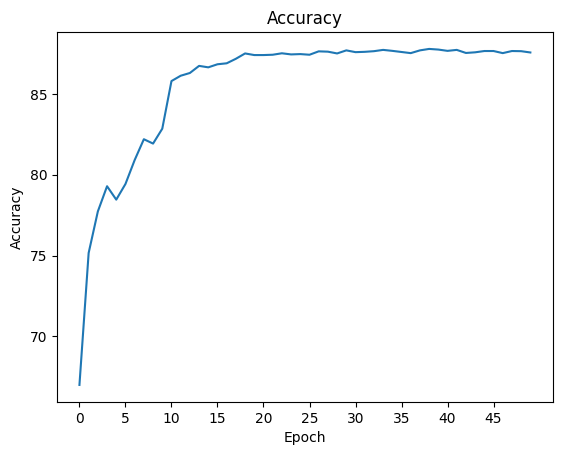

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

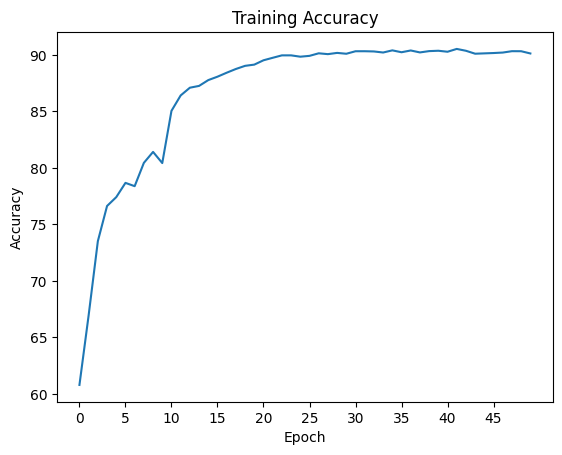

In [10]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

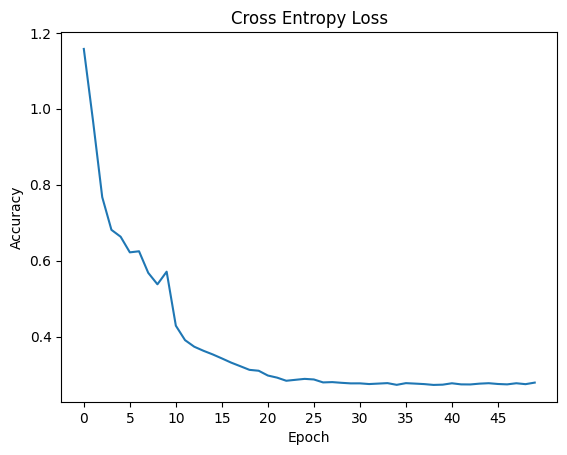

In [11]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()